## 比赛简介

【产业范例赛道 赛题链接】：[赛题链接](https://github.com/PaddlePaddle/Paddle/issues/50633)

【PaddlePaddle Hackathon 第四期 任务总览】：[第四期 任务总览](https://github.com/PaddlePaddle/Paddle/issues/51281)

【队名】：还是种地踏实

【GitHub id】leechenggg

【技术思路简介】：使用PaddleDetection套件中的RT-DETR-X模型对VisDrone-DET原图数据集进行训练评估以及推理部署

| 模型名称 | 评估方式 | IoU=0.50:0.95 | FPS（V100） |epoch|batchsize|lr|训练环境
| -------- | -------- | -------- |-------- |-------- |-------- |-------- |-------- |
| RT-DETR-X     |  原图    | 31.0     | 26.01     |100|4|0.0001|AIstudio4GPU |


上表中的模型均为使用**原图数据集训练**，AP精度均为**原图验证集**上评估的结果。FPS为本人在AIstudio V100上检测的结果平均值。本项目**单卡**可直接运行，4卡训练的模型已上传至根目录，可直接进行评估推理

## 一、项目背景
近年来，无人机航拍技术运用于各个领域，无论是水利建设，地质勘探，还是军事活动等，都运用到无人机航拍技术。本项目通过PaddleDetection套件中**RT-DETR-X**模型对VisDrone-DET原图数据集进行训练评估，在部署阶段采用**onnx**部署，以及**Gradio**界面展示，以期满足无人机检测的实际应用。

RT-DETR是第一个实时端到端目标检测器。支持通过使用不同的解码器层来灵活调整推理速度，而不需要重新训练，这有助于实时目标检测器的实际应用。RT-DETR-X实现了54.8%的AP和74FPS，在速度和精度方面都优于相同规模的所有YOLO检测器。

**无人机航拍检测场景对模型的快速性和准确性要求较高，基于此本文采用RT-DETR-X在VisDrone-DET数据集上进行检测**

根据PaddleDetection给出的模型性能对比，各模型结构和骨干网络的代表模型在COCO数据集上精度mAP和T4 TensorRT FP16上预测速度(FPS)对比如下：


| Model | Epoch | backbone  | input shape | $AP^{val}$ | $AP^{val}_{50}$| Params(M) | FLOPs(G) |  T4 TensorRT FP16(FPS) | Pretrained Model | config |
|:--------------:|:-----:|:----------:| :-------:|:--------------------------:|:---------------------------:|:---------:|:--------:| :---------------------: |:------------------------------------------------------------------------------------:|:-------------------------------------------:|
| RT-DETR-R18 | 6x |  ResNet-18 | 640 | 46.5 | 63.8 | 20 | 60 | 217 | [download](https://bj.bcebos.com/v1/paddledet/models/rtdetr_r18vd_dec3_6x_coco.pdparams) | [config](./rtdetr_r18vd_6x_coco.yml)
| RT-DETR-R34 | 6x |  ResNet-34 | 640 | 48.9 | 66.8 | 31 | 92 | 161 | [download](https://bj.bcebos.com/v1/paddledet/models/rtdetr_r34vd_dec4_6x_coco.pdparams) | [config](./rtdetr_r34vd_6x_coco.yml)
| RT-DETR-R50-m | 6x |  ResNet-50 | 640 | 51.3 | 69.6 | 36 | 100 | 145 | [download](https://bj.bcebos.com/v1/paddledet/models/rtdetr_r50vd_m_6x_coco.pdparams) | [config](./rtdetr_r50vd_m_6x_coco.yml)
| RT-DETR-R50 | 6x |  ResNet-50 | 640 | 53.1 | 71.3 | 42 | 136 | 108 | [download](https://bj.bcebos.com/v1/paddledet/models/rtdetr_r50vd_6x_coco.pdparams) | [config](./rtdetr_r50vd_6x_coco.yml)
| RT-DETR-R101 | 6x |  ResNet-101 | 640 | 54.3 | 72.7 | 76 | 259 | 74 | [download](https://bj.bcebos.com/v1/paddledet/models/rtdetr_r101vd_6x_coco.pdparams) | [config](./rtdetr_r101vd_6x_coco.yml)
| RT-DETR-L | 6x |  HGNetv2 | 640 | 53.0 | 71.6 | 32 | 110 | 114 | [download](https://bj.bcebos.com/v1/paddledet/models/rtdetr_hgnetv2_l_6x_coco.pdparams) | [config](rtdetr_hgnetv2_l_6x_coco.yml)
| **RT-DETR-X** | 6x |  HGNetv2 | 640 | **54.8** | 73.1 | 67 | 234 | **74** | [download](https://bj.bcebos.com/v1/paddledet/models/rtdetr_hgnetv2_x_6x_coco.pdparams) | [config](rtdetr_hgnetv2_x_6x_coco.yml)


## 二、环境准备
### 2.1 数据准备
VisDrone-DET是一个无人机航拍场景的小目标数据集，整理后的COCO格式原图数据集[下载链接](https://bj.bcebos.com/v1/paddledet/data/smalldet/visdrone.zip)，整理后的COCO格式切图数据集[下载链接](https://bj.bcebos.com/v1/paddledet/data/smalldet/visdrone_sliced.zip)，检测其中的10类，包括 pedestrian(1), people(2), bicycle(3), car(4), van(5), truck(6), tricycle(7), awning-tricycle(8), bus(9), motor(10)。

**注意**：整理后的数据集表示已经分配好训练集，验证集，测试集。本项目皆采用**原图数据集**进行训练评估，切图数据集一般与SAHI切图拼图方式结合使用。**SAHI通常适用于比赛环境，即只追求精度而不追求速度。因此本项目不采用SAHI推理，仅作操作示范。**

数据集来源：https://robotics.pkusz.edu.cn/resources/dataset/

下图为训练集部分图像：

![](https://ai-studio-static-online.cdn.bcebos.com/999b464ae941453f8a3e4052b2126df585c11c5544b043e68615cc386d645536)




In [1]:
# 组织数据目录
!mkdir MyDataset

In [2]:
# 解压原图数据集（仅运行一次）
!unzip -q /home/aistudio/data/data176741/visdrone.zip
!mv visdrone/* MyDataset
!rm -r visdrone

### 2.2 安装PaddleDetection以及依赖
有时用git clone安装会出现超时报错，可进入[PaddleDetection官网](https://github.com/PaddlePaddle/PaddleDetection)下载develop分支压缩包上传到目录，这里直接挂载数据集，然后解压

![](https://ai-studio-static-online.cdn.bcebos.com/bbdffe4c2fc64fc69f48941b396f21aa6251a39508fb44b5aff620ff5b5d6789)



1.解压PaddleDetection-develop数据集并重命名为PaddleDetection

In [3]:
!mkdir PaddleDetection

In [1]:
!unzip -q /home/aistudio/data/data218809/PaddleDetection-develop.zip
!mv PaddleDetection-develop/* PaddleDetection
!rm -r PaddleDetection-develop

2.采用线上下载方式，然后切换到develop分支

In [ ]:
# !git clone https://gitee.com/paddlepaddle/PaddleDetection.git
#!git checkout develop

In [1]:
%cd PaddleDetection

/home/aistudio/PaddleDetection


In [ ]:
# 安装PaddleDetection依赖
!pip install -r requirements.txt --user
!python setup.py install --user

### 2.3 训练数据分析
以下结果表明：
* 训练集共有6471张图像，343204个标注框

* 图像平均尺寸为（1002,1520）

* 目标尺寸占比的中位数（0.038,0.025）

* 图像分辨率大，小目标多


In [ ]:
!python tools/box_distribution.py \
--json_path ../MyDataset/train.json \
--out_img box_distribution.jpg

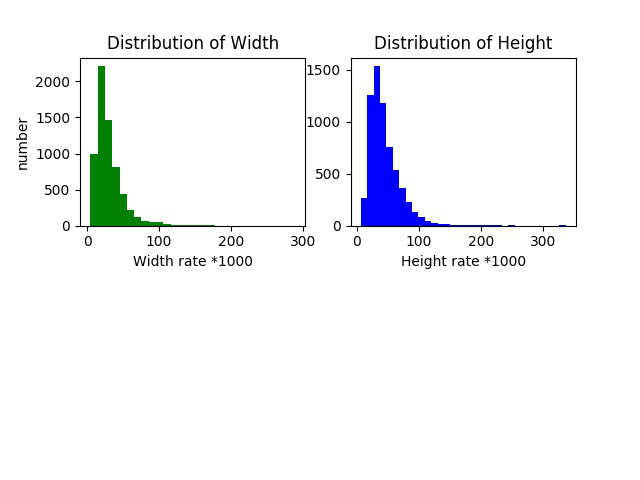

In [15]:
# 可视化
from PIL import Image 
im = Image.open('/home/aistudio/PaddleDetection/box_distribution.jpg')
im

## 三、模型选型
* 我们使用**RT-DETR-X**进行**原图数据集**训练，RT-DETR-X在backbone上采用paddle自研的HGNetv2，预训练模型采用PPHGNetV2_X，精度高速度快，非常适合实时目标图像检测场景。

* 在部署方面，**RT-DETR**可以导出onnx，使用onnxruntime部署推理，同时支持paddleinference部署套件


### 3.1 找到配置文件
配置文件在PaddleDetection/configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml，主要包含以下五个部分:

  * coco_detection.yml：数据配置
  * runtime.yml：训练运行
  * optimizer_6x.yml：超参数配置
  * rtdetr_r50vd.yml：网络架构
  * rtdetr_reader.yml：数据增强与bs设置
### 3.2 修改配置文件
找到配置文件后，需要对其进行修改，[参考PaddleDetection官方链接](https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.6/docs/advanced_tutorials/customization/detection.md)，修改后的文件放置在 **./configs**目录下。对于学习率训练轮数等超参数修改，因为官方是在4卡进行训练，因此在单卡情况下base_lr=0.0001/4 = 0.000025，本项目更改batchsize为6，调整学习率为**0.00005**。

在这里主要修改：
*  coco_detection.yml：因为有10类目标，num_classes=10，将训练和验证集路径修改到个人数据集路径，使用绝对路径以免报错

*  runtime.yml：将snapshot_epoch设置为2，每两轮评估及保存一次模型，硬盘容量不够大时，snapshot_epoch应设置的大一些

* optimizer_6x.yml：base_lr=0.00005，epoch=100，milestones（学习率衰减点）设置为100

* rtdetr_reader.yml：batch_size=6，如果单卡显存不够，就设置为4

本项目已修改好，直接运行即可

In [3]:
# 将修改后的配置文件替换掉原来的文件
!cp ../rtconfigs/coco_detection.yml configs/datasets/coco_detection.yml
!cp ../rtconfigs/runtime.yml configs/runtime.yml
!cp ../rtconfigs/optimizer_6x.yml configs/rtdetr/_base_/optimizer_6x.yml
!cp ../rtconfigs/rtdetr_reader.yml configs/rtdetr/_base_/rtdetr_reader.yml

## 四、模型训练

* 4卡训练：lr=0.0001，batchsize=4,训练时长需要7个小时,环境必须为四卡

* 恢复训练：当训练中断或者需要调整参数时，可指定model继续训练下去

* use_vdl=True表示使用BML自带的可视化网页进行数据模型可视化，--eval表示边训练边评估

In [ ]:
# 开始单卡训练
# 恢复训练 -r output/rtdetr_hgnetv2_x_6x_coco/best_model
!python tools/train.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
--use_vdl=True \
--vdl_log_dir=../work/ \
--eval 

4卡训练时，首先将配置文件中的lr=0.0001，batchsize=4分别进行更改，然后重新将修改后的配置文件替换掉原来的文件，进入4卡环境训练

In [ ]:
# 开始四卡训练
# 恢复训练 -r output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams
# !export CUDA_VISIBLE_DEVICES=0,1,2,3
# !python -m paddle.distributed.launch --gpus 0,1,2,3 tools/train.py \
# -c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml --fleet \
# --use_vdl=True \
# --vdl_log_dir=../work/ \
# --eval 

### 训练过程可视化

![](https://ai-studio-static-online.cdn.bcebos.com/23a92d90887d464f90fe6ab1f0d6759caf086d38458b465f9489329d4780adab)


## 五、评估方式

对于小目标，有两种推理方式，一种是**直接原图评估**，另一种是使用**SAHI**将原图切开再拼起来评估。

SAHI(Slicing Aided Hyper Inference )算法属于数据增强的方法，为了处理小对象检测问题，SAHI算法在fine-tuning和推理阶段提出了一种基于切片的通用框架。将输入图像分割成重叠的块，这样小目标物体的像素区域相对较大一些。适用于遥感图像、4k无人机航拍图像等高质量图像。PaddleDetection集成了切图和拼图的功能，可以直接在检测框架里使用，并且提供了用于训练和推理的场景工具。


### 5.2 默认原图评估

In [ ]:
# 模型评估
!python -u tools/eval.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
-o weights=output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams

### 原图评估指标
*  Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.310
*  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.520
*  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
*  Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
*  Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.429
*  Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.618
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.127
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.348
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.367
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.584
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.737
* ppdet.engine INFO: Total sample number: 548, average FPS: 27.679056799747872


### 5.3 SAHI子图拼图评估

子图拼图评估的意思是先将输入的原图切分成多个小分辨的图像，分别进行推理，推理后再按照一定的重叠率进行组合，用速度换取精度，这也是SAHI为什么也可以提升小目标检测精度的原因。slice_size表示切图的子图尺寸大小，**sliced_size越小，切的图越多，推理就越慢**，这里直接使用默认的（640，640）。要使用子图拼图评估，需要对配置文件进行更改，更改内容如下：

* rtdetr_reader.yml： EvalReader的batch_size=1

* coco_detection.yml：EvalDataset确定为!SlicedCOCODataSet评估方式


本项目已经做了更改，直接copy即可


In [ ]:
# 安装SAHI库
!pip install sahi

In [17]:
!cp ../rtconfigs/coco_detection-sahi.yml configs/datasets/coco_detection.yml
!cp ../rtconfigs/rtdetr_reader-sahi.yml configs/rtdetr/_base_/rtdetr_reader.yml

### 说明
* 设置--slice_infer表示切图预测并拼装重组结果，如果不使用则不写，注意需要确保EvalDataset的数据集类是选用的SlicedCOCODataSet而不是COCODataSet；
* 设置--overlap_ratio表示子图间重叠率，可以自行修改选择合适的子图尺度sliced_size和子图间重叠率overlap_ratio
* 设置--combine_method表示子图结果重组去重的方式，默认是nms；
* 设置--match_threshold表示子图结果重组去重的阈值，默认是0.6；
* 设置--match_metric表示子图结果重组去重的度量标准，默认是ios表示交小比(两个框交集面积除以更小框的面积)，也可以选择交并比iou(两个框交集面积除以并集面积)，精度效果因数据集而而异，但选择ios预测速度会更快一点；

In [ ]:
# 模型评估
!python -u tools/eval.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
-o weights=output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams \
--slice_infer \
--combine_method=nms \
--match_threshold=0.6 \
--match_metric=ios

### SAHI子图拼图评估指标
精度**提升了3.3**个点，同时伴随着**FPS大幅度下降**

* Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.343
*  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.575
*  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.343
*  Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.261
*  Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.446
*  Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.132
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.387
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.508
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.438
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.603
*  Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.638
* ppdet.engine INFO: Total sample number: 548, average FPS: 1.0315984783954413

## 六、预测推理
在paddledetection套件中可以预测单张图片也可以批量预测，只需修改一些参数，十分方便


### 6.1原图推理

![](https://ai-studio-static-online.cdn.bcebos.com/1decd71628d64df19e3c9077329af4543c5f93bcdb254da183d524e49045362f)




In [ ]:
# 挑一张验证集的图片展示预测效果
!python tools/infer.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
-o weights=output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams \
--infer_img=../MyDataset/VisDrone2019-DET-test_dev/images/0000006_00611_d_0000002.jpg \
--draw_threshold=0.40 \
--save_results=True

In [ ]:
# 批量预测
!python tools/infer.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
-o weights=output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams \
--infer_dir=../MyDataset/VisDrone2019-DET-test_dev/images/ \
--output_dir=../output/infer_images/ \
--draw_threshold=0.4 \
--save_results=True

### 6.2 SAHI子图拼成原图推理

可以看到，使用SAHI推理检测出的小目标相对直接使用原图推理变多了,同时大目标检测效果变差

![](https://ai-studio-static-online.cdn.bcebos.com/56df69f1f4164f1ebfaeab9cec1db34171e4b2d334eb4bd68eff3772411ec268)



In [ ]:
# 单张预测
!python tools/infer.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
-o weights=output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams \
--infer_img=../MyDataset/VisDrone2019-DET-test_dev/images/0000006_00611_d_0000002.jpg \
--draw_threshold=0.40 \
--slice_infer --slice_size 640 640 --overlap_ratio 0.25 0.25 --combine_method=nms --match_threshold=0.6 --match_metric=ios --save_results=True

In [ ]:
# 批量预测(时间较长)
!python tools/infer.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
-o weights=output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams  --infer_dir=../MyDataset/VisDrone2019-DET-test_dev/images/ \
--draw_threshold=0.4 --slice_infer --slice_size 640 640 --overlap_ratio 0.25 0.25 --combine_method=nms --match_threshold=0.6 --match_metric=ios

## 七、部署模型

### 7.1导出部署模型

In [ ]:
#导出部署模型
!python tools/export_model.py \
-c configs/rtdetr/rtdetr_hgnetv2_x_6x_coco.yml \
-o weights=output/rtdetr_hgnetv2_x_6x_coco/best_model.pdparams 

### 7.2转换模型至ONNX

In [ ]:
# 安装Paddle2ONNX 和 ONNX
!pip install onnx==1.13.0
!pip install paddle2onnx==1.0.5

In [ ]:
# 导出onnx文件
!paddle2onnx --model_dir=./output_inference/rtdetr_hgnetv2_x_6x_coco/ \
            --model_filename model.pdmodel  \
            --params_filename model.pdiparams \
            --opset_version 16 \
            --save_file rtdetr_hgnetv2_x_6x_coco.onnx

### 7.3ONNXRUNTIME部署
![](https://ai-studio-static-online.cdn.bcebos.com/4268647721a74dc1bda2f58a2b2385225d19fcebfefd40899e8682b95be0e470)


In [ ]:
# 安装onnxruntime
!pip install onnxruntime --user

**如遇报错**：先保存文件，然后重启内核再次运行

In [10]:
# 推理可视化
import onnxruntime as rt
import cv2
import numpy as np

sess = rt.InferenceSession("/home/aistudio/PaddleDetection/rtdetr_hgnetv2_x_6x_coco.onnx")
img = cv2.imread("/home/aistudio/MyDataset/VisDrone2019-DET-test_dev/images/0000006_00611_d_0000002.jpg")
org_img = img
im_shape = np.array([[float(img.shape[0]), float(img.shape[1])]]).astype('float32')
img = cv2.resize(img, (640,640))
scale_factor = np.array([[float(640/img.shape[0]), float(640/img.shape[1])]]).astype('float32')
img = img.astype(np.float32) / 255.0
input_img = np.transpose(img, [2, 0, 1])
image = input_img[np.newaxis, :, :, :]
output_dict = ["reshape2_83.tmp_0","tile_3.tmp_0"]
inputs_dict = {
    'im_shape': im_shape,
    'image': image,
    'scale_factor': scale_factor
}
result = sess.run(output_dict, inputs_dict)
for item in result[0]:
    if item[1] > 0.4:
        if item[0] == 0:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (255,0,0), 2)
            cv2.putText(org_img, "pedestrian", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 1:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (0,255,0), 2)
            cv2.putText(org_img, "people", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 2:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (0,0,255), 2)
            cv2.putText(org_img, "bicycle", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 3:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (225,225,0), 2)
            cv2.putText(org_img, "car", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 4:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
            cv2.putText(org_img, "van", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 5:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
            cv2.putText(org_img, "truck", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 6:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
            cv2.putText(org_img, "tricycle", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 7:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
            cv2.putText(org_img, "awning-tricycle", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        elif item[0] == 8:
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
            cv2.putText(org_img, "bus", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        else :
            cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
            cv2.putText(org_img, "motor", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
cv2.imwrite("/home/aistudio/work/result.png", org_img)

True

### 7.4Gradio应用部署

如何使用Gradio可参考我上篇项目[【Gradio应用部署】使用FastDeploy轻松部署80类物体检测应用](https://aistudio.baidu.com/aistudio/projectdetail/6110849)

主要包含两个部分：定义推理函数以及创建Gradio界面，在线预览demo如下所示，直接打开launch/demo.gradio.py即可体验应用

```

# 导入包
import gradio as gr
import onnxruntime as rt
import numpy as np
import cv2
import pandas as pd
from PIL import Image

sess = rt.InferenceSession("/home/aistudio/launch/rtdetr_hgnetv2_x_6x_coco.onnx")

# 定义推理函数，输入图像地址，返回检测图像
def infer(img, threshold):
    if isinstance(img, str):
        img = cv2.imread('/home/aistudio/launch/'+img)
        org_img = img
    else:
        org_img = img
    im_shape = np.array([[float(img.shape[0]), float(img.shape[1])]]).astype('float32')
    img = cv2.resize(img, (640,640))
    scale_factor = np.array([[float(640/img.shape[0]), float(640/img.shape[1])]]).astype('float32')
    img = img.astype(np.float32) / 255.0
    input_img = np.transpose(img, [2, 0, 1])
    image = input_img[np.newaxis, :, :, :]
    output_dict = ["reshape2_83.tmp_0","tile_3.tmp_0"]
    inputs_dict = {
        'im_shape': im_shape,
        'image': image,
        'scale_factor': scale_factor
    }
    result = sess.run(output_dict, inputs_dict)
    for item in result[0]:
        if item[1] > threshold:
            if item[0] == 0:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (255,0,0), 2)
                cv2.putText(org_img, "pedestrian", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 1:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (0,255,0), 2)
                cv2.putText(org_img, "people", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 2:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (0,0,255), 2)
                cv2.putText(org_img, "bicycle", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 3:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (225,225,0), 2)
                cv2.putText(org_img, "car", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 4:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
                cv2.putText(org_img, "van", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 5:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
                cv2.putText(org_img, "truck", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 6:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
                cv2.putText(org_img, "tricycle", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 7:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
                cv2.putText(org_img, "awning-tricycle", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            elif item[0] == 8:
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
                cv2.putText(org_img, "bus", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            else :
                cv2.rectangle(org_img, (int(item[2]), int(item[3])), (int(item[4]), int(item[5])), (128,0,128), 2)
                cv2.putText(org_img, "motor", (int(item[2]), int(item[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
    return org_img

# Gradio界面端
with gr.Blocks() as demo:    
    gr.Markdown("# RT-DETR-X无人机航拍检测")
            
    with gr.Tab("选择测试图片"):
        files = ['car.jpg','pedestrian.jpg','truck.jpg']
        drop_down = gr.Dropdown(choices=files,value=files[0])
        threshold = gr.Slider(0, 1, value=0.4, label="设定阈值")
        button = gr.Button("执行检测",variant="primary")        
        gr.Markdown("## 预测输出")
        out_img = gr.Image()        
        button.click(infer,
                     inputs=[drop_down,threshold],
                     outputs=out_img)
               
    with gr.Tab("上传本地图片"):
        input_img = gr.Image()
        threshold = gr.Slider(0, 1, value=0.4, label="阈值")
        button = gr.Button("执行检测",variant="primary")
        gr.Markdown("## 预测输出")
        out_img = gr.Image()        
        button.click(infer,
                     inputs=[input_img,threshold],
                     outputs=out_img)

demo.launch()



## 八、参考资料与总结

* 在这里感谢导师[lumaojushi](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/572413)的帮助！感谢比赛官方的算力支持！

* [RT-DETR：全新ViT系列模型助力铁路工人安全作业[Gradio版本发布！]](https://aistudio.baidu.com/aistudio/projectdetail/6000200)

* [PaddleDetection官网](https://github.com/PaddlePaddle/PaddleDetection)

* 本项目基于PaddleDetection套件使用RT-DETR-X模型对数据集进行训练评估，训练提供了单卡与4卡两种方式，评估提供了原图评估以及切图两种方法，模型的速度和精度都达到了不错的效果。接下来可以通过一定方式对模型精度进一步提升，同时进行视频流部署，达到产业应用的效果。